In [1]:
import matplotlib.pyplot as plt
import numpy
%matplotlib inline
import math 
um={}
um["y0"]=0.1
um["y1"]=0.1
for i in range (2,5001):
    ex=math.exp(-1*um["y"+str(i-1)]*um["y"+str(i-1)])
    y=(0.8-0.5*ex)*um["y"+str(i-1)]-(0.3+0.9*ex)*um["y"+str(i-2)]+0.1*math.sin(um["y"+str(i-1)]*math.pi)
    um["y"+str(i)]=y
#print(um)
#print("\n")
inputs=[]
for i in range (4,5001):
    temp=[]
    for j in range (i-4,i):
        temp.append(um["y"+str(j)])
    inputs.append(temp)   
#print(len(um),len(inputs))
outputs=[]
for i in range (0,4997):
   # print(inputs[i],um["y"+str(i+4)])
    outputs.append(um["y"+str(i+4)])
#print(inputs)   
#print(len(outputs))

#from filters import (APA1, APA2, APA3, APA4, CKLMS, KAPA1, KAPA2, KAPA3, KAPA4, KLMS, KRLS, LMS, QKLMS, get_training_error)
#def gen_test_data():
    # Original binary signal
    #s = numpy.random.randint(0, 2, size=(1, 2500))
    #s = 2 * s - 1

    # Nonlinear channel
    #tmp = numpy.copy(s)
    #tmp[1:] = tmp[0:-1]
    #tmp[0] = 0
    #x = s + 0.5 * tmp
    #ns = 0.4 * numpy.random.normal(0, 1, s.shape[1])
    # non linearity
    #r = x - 0.9 * (x ** 2) + ns

    # time embedding
    #TD = 4
    # equalization time lag
    #D = 2

    # dataset size
    #N_tr = 300
    #N_te = 20

    # train data
   # X = numpy.zeros((N_tr, TD))
    #for k in range(N_tr):
       # X[k, :] = r[0, k: k + TD]

    # test data
   # X_te = numpy.zeros((N_te, TD))
    #for k in range(N_te):
       # X_te[k, :] = r[0, k + N_tr: k + TD + N_tr]

    # Desired signal
   # T = numpy.zeros((N_tr, 1))
   # for i in range(N_tr):
       # T[i, 0] = s[0, D + i]

    # Desire signal testing
   # T_te = numpy.zeros((N_te, 1))
    #for i in range(N_te):
       # T_te[i, 0] = s[0, D + i + N_tr]

   # return X, X_te, T, T_te, TD

In [7]:
import numpy as np


class Kernel:
    def kernel(self, a, b):
        norm = np.linalg.norm(a - b)
        term = (norm * norm) / (2 * self.sigma * self.sigma)
        return np.exp(-1 * term)


class CKLMS(Kernel):
    def __init__(
        self,
        first_input,
        first_output,
        learning_step=0.5,
        sigma=0.5,
        sigma_cor=0.5
    ):
        self.inputs = [first_input]
        self.errors = [first_output]
        self.learning_step = learning_step
        self.sigma = sigma
        self.sigma_cor = sigma_cor

    def predict(self, new_input):
        estimate = 0
        for i in range(0, len(self.inputs)):
            term = np.exp(
                -(self.errors[i] * self.errors[i]) /
                (2 * self.sigma_cor * self.sigma_cor))
            ker_eval = self.kernel(self.inputs[i], new_input)
            estimate += (
                self.learning_step * term * self.errors[i] * ker_eval)
        return estimate

    def update(self, new_input, new_output):
        self.errors.append(new_output - self.predict(new_input))
        self.inputs.append(new_input)

    def name(self):
        return 'CKLMS'


class KLMS(Kernel):
    def __init__(
        self,
        num_params,
        first_input=None,
        first_output=None,
        learning_step=0.5,
        sigma=1
    ):
        if first_input is not None:
            self.inputs = [first_input]
        else:
            self.inputs = [np.zeros(num_params)]
        if first_output is not None:
            self.weights = [first_output * learning_step]
        else:
            self.weights = [0]
        self.learning_step = learning_step
        self.sigma = sigma
        self.error = None

    def predict(self, new_input):
        estimate = 0
        for i in range(0, len(self.weights)):
            addition = self.weights[i] * self.kernel(self.inputs[i], new_input)
            estimate += addition
        return estimate

    def update(self, new_input, expected):
        self.error = expected - self.predict(new_input)
        self.inputs.append(new_input)
        new_weights = self.learning_step * self.error
        self.weights.append(new_weights)

    def name(self):
        return 'KLMS'


class KRLS(Kernel):
    def __init__(
        self,
        first_input,
        first_output,
        reg_param=0.1,
        sigma=1
    ):
        self.reg_param = reg_param
        self.sigma = sigma
        self.Q = np.array(
            [1 / (reg_param + self.kernel(first_input, first_input))])
        self.weights = np.array([self.Q * first_output])
        self.inputs = [first_input]

    def predict(self, new_input):
        h = np.array([
            self.kernel(new_input, old_input) for old_input in self.inputs
        ]).reshape(1, len(self.inputs))
        return h.dot(self.weights)

    def update(self, new_input, expected):
        h = np.array([
            self.kernel(new_input, old_input) for old_input in self.inputs
        ]).reshape(len(self.inputs), 1)
        ht = h.T
        z = self.Q.dot(h)
        zt = z.T
        r = self.reg_param + self.kernel(new_input, new_input) - zt.dot(h)
        Q_size = len(z) + 1
        new_Q = np.zeros((Q_size, Q_size))
        new_Q[0:Q_size - 1, 0:Q_size - 1] = self.Q * r + z.dot(zt)
        new_Q[0:Q_size - 1, Q_size - 1:Q_size] = -z
        new_Q[Q_size - 1:Q_size, 0:Q_size - 1] = -zt
        new_Q[Q_size - 1][Q_size - 1] = 1
        self.Q = new_Q
        error = expected - ht.dot(self.weights)
        new_weights = np.zeros((Q_size, 1))
        new_weights[0:Q_size - 1, 0:1] = self.weights - z * (1 / r) * error
        new_weights[Q_size - 1][0] = (1 / r) * error
        self.weights = new_weights
        self.inputs.append(new_input)

        # reduce the regularization as we get more data
        self.reg_param *= 0.9

    def name(self):
        return 'KRLS'


class LMS:
    def __init__(self, num_params, learning_step):
        self.weights = np.ones(num_params)
        self.learning_step = learning_step

    def predict(self, new_input):
        return self.weights.dot(new_input)

    def update(self, new_input, desired_output):
        prediction_error = desired_output - self.predict(new_input)
        self.weights += self.learning_step * prediction_error * new_input

    def name(self):
        return 'LMS'


class QKLMS(KLMS):
    def __init__(
        self,
        num_params,
        first_input=None,
        first_output=None,
        learning_step=0.5,
        min_distance=1,
        sigma=0.5
    ):
        super().__init__(
            num_params, first_input, first_output, learning_step, sigma)
        self.min_distance = min_distance

    def update(self, new_input, expected):
        self.error = expected - self.predict(new_input)
        current_dist = 1e10
        current_index = None
        for i in range(0, len(self.inputs)):
            distance = np.linalg.norm(new_input - self.inputs[i])
            if distance < self.min_distance and distance < current_dist:
                current_dist = distance
                current_index = i
        if current_index is not None:
            self.weights[current_index] += self.learning_step * self.error
        else:
            new_weights = self.learning_step * self.error
            self.inputs.append(new_input)
            self.weights.append(new_weights)

    def name(self):
        return 'QKLMS'

class KAPA1(Kernel):
    def __init__(self, u_0, d_0, K, eta, sigma):
        self.a = [eta * d_0]
        self.u = [u_0]
        self.d = [d_0]
        self.eta = eta
        self.K = K
        self.sigma = sigma

    def predict(self, x):
        ans = 0
        for i in range(len(self.a)):
            ans += self.a[i] * self.kernel(self.u[i], x)
        return ans

    def update(self, x, d):
        tmp = len(self.a)
        for i in range(max(0, tmp - self.K), tmp):
            y = self.predict(self.u[i])
            e = self.d[i] - y
            self.a[i] += self.eta * e

        error = d - self.predict(x)
        self.u.append(x)
        self.a.append(self.eta * error)
        self.d.append(d)

    def name(self):
        return 'KAPA1'


class KAPA2(Kernel):
    def __init__(
        self,
        first_input,
        first_output,
        learning_step=0.5,
        sigma=1,
        sample_size=5
    ):
        self.weights = [learning_step * first_output]
        self.inputs = [first_input]
        self.outputs = [first_output]
        self.learning_step = learning_step
        self.sigma = sigma
        self.sample_size = sample_size

    def predict(self, new_input):
        estimate = 0
        for i in range(0, len(self.weights)):
            estimate += self.weights[i] * self.kernel(self.inputs[i], new_input)
        return estimate

    def calc_G(self):
        tmp = len(self.weights)
        tmp2 = min(tmp, self.sample_size)
        G = np.zeros((tmp2, tmp2))
        for i in range(max(0, tmp - self.sample_size), tmp):
            for j in range(max(0, tmp - self.sample_size), tmp):
                i_g = i - max(0, tmp - self.sample_size)
                j_g = j - max(0, tmp - self.sample_size)
                G[j_g][i_g] = self.kernel(self.inputs[i], self.inputs[j])
        return G

    def update(self, new_input, new_output):
        tmp = len(self.weights)
        errors = []
        for k in range(max(0, tmp - self.sample_size), tmp):
            errors.append(self.outputs[k] - self.predict(self.inputs[k]))
        err_vec = np.array(errors)

        tmp2 = min(tmp, self.sample_size)
        G = self.calc_G()
        G_inv = np.linalg.inv(G + 1e-5 * np.identity(tmp2))
        weight_deltas = G_inv.dot(err_vec) * self.learning_step
        for i in range(max(0, tmp - self.sample_size), tmp):
            self.weights[i] += (
                weight_deltas[i - max(0, tmp - self.sample_size)])

        estimate = self.predict(new_input)
        error = new_output - estimate
        self.inputs.append(new_input)
        self.outputs.append(new_output)
        self.weights.append(self.learning_step * error)

    def name(self):
        return 'KAPA2'


class KAPA3(KAPA1):
    def __init__(
        self,
        first_input,
        first_output,
        learning_step=0.5,
        sigma=1,
        sample_size=5,
        reg_param=0.1
    ):
        super().__init__(
            first_input, first_output, sample_size, learning_step, sigma)
        self.reg_param = reg_param

    def update(self, new_input, new_output):
        tmp = len(self.a)
        for i in range(0, tmp):
            y = self.predict(self.u[i])
            e = self.d[i] - y
            if i >= max(0, tmp - self.K):
                self.a[i] *= (1 - self.eta * self.reg_param)
                self.a[i] += self.eta * e
            else:
                self.a[i] *= (1 - self.eta * self.reg_param)

        error = new_output - self.predict(new_input)
        self.u.append(new_input)
        self.a.append(self.eta * error)
        self.d.append(new_output)

    def name(self):
        return 'KAPA3'


class KAPA4(KAPA2):

    def __init__(
        self,
        first_input,
        first_output,
        learning_step=0.5,
        sigma=1,
        sample_size=5,
        reg_param=0.1
    ):
        super().__init__(
            first_input, first_output, learning_step, sigma, sample_size)
        self.reg_param = reg_param

    def update(self, new_input, new_output):
        G = self.calc_G()
        G_inv = np.linalg.inv(G + self.reg_param * np.identity(G.shape[0]))

        tmp = len(self.weights)
        d_np = np.array(self.outputs[max(0, tmp - self.sample_size):tmp])
        d_est = G_inv.dot(d_np)

        for i in range(0, tmp):
            i_est = self.predict(self.inputs[i])
            i_err = self.outputs[i] - i_est
            if i >= max(0, tmp - self.sample_size):
                self.weights[i] *= (1 - self.learning_step)
                self.weights[i] += (
                    self.learning_step *
                    d_est[i - max(0, tmp - self.sample_size)])
            else:
                self.weights[i] *= (1 - self.learning_step)

        error = new_output - self.predict(new_input)
        self.outputs.append(new_output)
        self.inputs.append(new_input)
        self.weights.append(self.learning_step * error)

    def name(self):
        return 'KAPA4'

class RMS:
    def __init__(self, num_params):
        self.num_params = num_params
        self.weights = np.ones(num_params)
        self.previous_inputs = []

    def predict(self, new_input):
        return self.weights.dot(new_input)

    def calc_time_avg_corr(self, new_input):
        R = np.eye(self.num_params)
        for input_data in self.previous_inputs:
            row = input_data.reshape(self.num_params, 1)
            col = input_data.reshape(1, len(input_data))
            R += row.dot(col)
        new_row = new_input.reshape(self.num_params, 1)
        new_col = new_input.reshape(1, self.num_params)
        R += new_row.dot(new_col)
        return R

    def calc_gain_vector(self, new_input):
        R = self.calc_time_avg_corr(new_input)
        return np.linalg.inv(R).dot(new_input)

    def update_weights(self, new_input, desired_output):
        prediction_error = desired_output - self.predict(new_input)
        k = self.calc_gain_vector(new_input)
        self.weights += k.dot(prediction_error)



def get_training_error(adap_filter, X, X_te, T, T_te, TD):
    N_tr = X.shape[0]
    N_te = X_te.shape[0]
    predictions=[]
    mse = []
    e=[]
    for i in range(N_tr):
        errors = []
        p=[]
        for j in range(N_te):
            p.append(adap_filter.predict(X_te[j]))
            errors.append(T_te[j] - adap_filter.predict(X_te[j]))
        predictions.append(p)
        e.append(errors)
        errors = np.array(errors)
        mse.append(np.mean(errors ** 2))

        adap_filter.update(X[i], T[i])
   # print(mse)
    return mse# predictions # mse #,predictions,e

0.11105900499924914


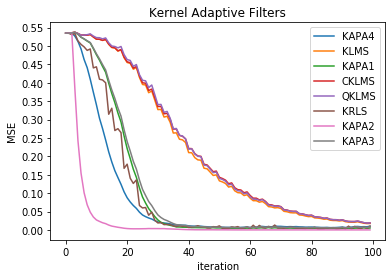

In [48]:
def gen_sin_data():
    X = numpy.arange(0, 2 * numpy.pi, numpy.pi / 1000)
    T = numpy.sin(X)
    X_te = numpy.arange(0, 2 * numpy.pi, numpy.pi / 10)
    T_te = numpy.sin(X_te)
    return X, X_te, T, T_te, 1


#seed = 337980  # this is to reproduce the results
#print('seed', seed)
#numpy.random.seed(seed)

#X, X_te, T, T_te, TD = gen_test_data()
X=numpy.asarray(inputs[0:100])
X_te=numpy.asarray(inputs[100:120])
T=numpy.asarray(outputs[0:100])
T_te=numpy.asarray(outputs[100:120])
display(KLMS(4, X[0], T[0], 0.2, 2.25))
filters = [
        #LMS(4, 0.01),
        KAPA4(X[0], T[0], 0.2, 2.25, 10),
        KLMS(4, X[0], T[0], 0.2, 2.25),
        KAPA1(X[0], T[0], 10, 0.2, 2.25),
        CKLMS(X[0], T[0], 0.2, 2.25, 2),
        QKLMS(4,X[0], T[0], 0.2, 0.225, 2.25),
        KRLS(X[0], T[0], 0.5, 2.25),     
        KAPA2(X[0], T[0], 0.2, 2.25, 10),
        KAPA3(X[0], T[0], 0.2, 2.25, 10)
        

    ]
for fi in filters:
    err = get_training_error(fi, X, X_te, T, T_te, 4)
    plt.plot(err[0:], label=fi.name())
#print(err)
rmsee=[err]
print(numpy.asarray(rmsee).mean())
plt.legend()
plt.yticks(np.arange(0, 0.6, 0.05))
#plt.xticks(np.arange(0, 1, 0.25))
plt.ylabel('MSE')
plt.xlabel('iteration')
plt.title('Kernel Adaptive Filters')
plt.savefig('./KernelFilters.png')
#from matplotlib.pyplot import figure
#figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k').show()
#plt.figure(figsize=(20,10)).show()
plt.show()
    

In [13]:
print(err)

[0.5351462659963834, 0.534774274870667, 0.5352357731069272, 0.5368500167767554, 0.5320277146702511, 0.5239875294859552, 0.5192567558513683, 0.5141061520954856, 0.5093042025765808, 0.4944606224650756, 0.47876735685105326, 0.4649763204318228, 0.4493106363674772, 0.4347484137593723, 0.4066417673051882, 0.380513749360665, 0.35743852093686945, 0.33144414493970853, 0.30924699712024273, 0.2724665122188254, 0.24005562365470134, 0.21427198908325268, 0.18642973633145005, 0.16530579845663726, 0.13554016087565895, 0.11025461056397128, 0.09352441538260653, 0.07720016874811333, 0.06610619917340269, 0.05230409328083148, 0.04070763035906164, 0.03365223636660538, 0.02846722250123627, 0.025191620755685963, 0.021205408829419393, 0.01735904527388305, 0.014424814231362656, 0.013360394997801731, 0.012515215864925424, 0.011941265205245325, 0.010493407280242145, 0.00939057255183968, 0.008882260513127717, 0.00866619724320403, 0.008832337671825636, 0.008235049525467126, 0.008113347965635596, 0.00745392135960859

In [32]:
import numpy as np

z = range(0,4000,10)
D = max(z)
a,b,A = 5,75,10 
lam = 0.01 

vel = err#A*np.exp(-lam*z)*np.sin((a*pi*z)/D)*np.sin((b*pi*z)/D)

ValueError: x and y must have same first dimension, but have shapes (100,) and (400,)

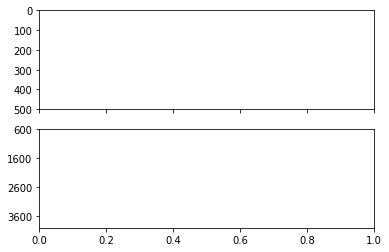

In [33]:
ax1,ax2 = brokenAxesDemo(vel,z)

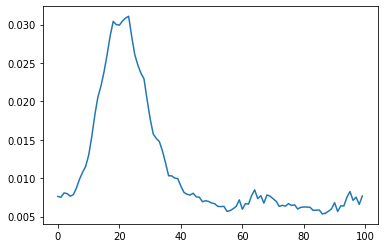

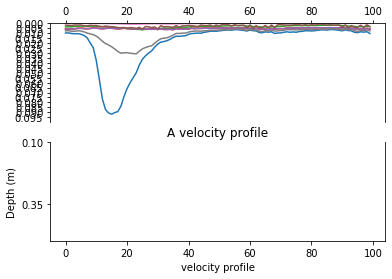

In [45]:
import matplotlib.pylab as plt

#create figure
plt.figure()

#get axes handle
ax = plt.gca()

#flip y-axis 
#ax.invert_yaxis()

#plot data
#plt.plot(vel,z)
plt.plot(err[0:])


fig,(ax1,ax2) = plt.subplots(2, 1, sharex=True)

#set the "zoom" or the y-limits on each subplots
ax1.set_ylim(0,0.1)
ax2.set_ylim(0.1,0.5)

#set ytick marks for upper plot (optional, but the default tick marks may not look nice)
upper_yticks = np.arange(0,0.1,0.005) 
ax1.set_yticks(upper_yticks)

#set ytick marks for lower plot (optional, but the default tick marks may not look nice)
lower_yticks = np.arange(0.1,0.5,0.25)
ax2.set_yticks(lower_yticks)

#invert the y-axis (since we are plotting profile data)
ax1.invert_yaxis()
ax2.invert_yaxis()

#now plot data into each subplot
for fi in filters:
    err = get_training_error(fi, X, X_te, T, T_te, 4)
    ax1.plot(err[0:], label=fi.name())
    ax2.plot(err[0:], label=fi.name())
#ax1.plot(err)
#ax2.plot(err)

#remove the bottom border from the top plot and the upper border from the bottom plot
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

#show only top x-axis tick marks on the top plot
ax1.xaxis.tick_top() 
ax1.tick_params(labeltop='off') # hides the labels from the top x-axis

#show only bottom x-axis tick marks on the lower plot
ax2.xaxis.tick_bottom()


#squeeze plots closer
plt.subplots_adjust(hspace=0.2) #set to



#add labels
plt.xlabel('velocity profile')
plt.ylabel('Depth (m)')
plt.title('A velocity profile')

#display the plot
plt.show()

In [28]:
def brokenAxesDemo(vel,z):
    
    #I am  making this code into a function so that I can use it again in this demo.
    #It's not a very useful function since a lot of things are hard coded.

    #create a new figure with two subplots
    fig,(ax1,ax2) = plt.subplots(2, 1, sharex=True)

    #set the "zoom" or the y-limits on each subplots
    ax1.set_ylim(0,500)
    ax2.set_ylim(600,4000)
    
    #set ytick marks for upper plot (optional, but the default tick marks may not look nice)
    upper_yticks = np.arange(0,501,100) 
    ax1.set_yticks(upper_yticks)
    
    #set ytick marks for lower plot (optional, but the default tick marks may not look nice)
    lower_yticks = np.arange(600,4000,1000)
    ax2.set_yticks(lower_yticks)
    
    #invert the y-axis (since we are plotting profile data)
    ax1.invert_yaxis()
    ax2.invert_yaxis()

    #now plot data into each subplot
    ax1.plot(vel,z)
    ax2.plot(vel,z)
    
    #remove the bottom border from the top plot and the upper border from the bottom plot
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    
    #show only top x-axis tick marks on the top plot
    ax1.xaxis.tick_top() 
    ax1.tick_params(labeltop='off') # hides the labels from the top x-axis
    
    #show only bottom x-axis tick marks on the lower plot
    ax2.xaxis.tick_bottom()
    
    
    #squeeze plots closer
    plt.subplots_adjust(hspace=0.2) #set to zero, if you want to join the two plots
    
    
    #add figure labels
    ax2.set_xlabel('velocity')
    ax1.set_ylabel('Depth (m)')
    ax2.set_ylabel('Depth (m)')
    ax1.set_title('Velocity profile after zooming into upper 500m.')
    
    return ax1, ax2